# 1. Thêm các thư viện cần thiết

In [1]:
import os
import itertools
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision.transforms import v2

from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# 2. Chuẩn bị dữ liệu

In [3]:
# Nhập dữ liệu từ file
def load_data(data_path):
    X_train = np.load(f'{data_path}/A01T_X.npy')
    y_train = np.load(f'{data_path}/A01T_Y.npy')
    X_test = np.load(f'{data_path}/A01E_X.npy')
    y_test = np.load(f'{data_path}/A01E_Y.npy')

    for i in range(2, 10, 1):
        xt = np.load(f'{data_path}/A0{i}T_X.npy')
        yt = np.load(f'{data_path}/A0{i}T_Y.npy')
        xv = np.load(f'{data_path}/A0{i}E_X.npy')
        yv = np.load(f'{data_path}/A0{i}E_Y.npy')

        X_train = np.concatenate([X_train, xt])
        y_train = np.concatenate([y_train, yt])
        X_test = np.concatenate([X_test, xv])
        y_test = np.concatenate([y_test, yv])

    return X_train, X_test, y_train, y_test

In [4]:
data_path = '/kaggle/input/eeg-preprocessed-data/IndividualData'
X_train, X_test, y_train, y_test = load_data(data_path)
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (2592, 22, 1875)
y_train shape: (2592,)
X_test shape: (2592, 22, 1875)
y_test shape: (2592,)


In [5]:
class EEGSpectralDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Lấy ảnh và nhãn
        image = self.X[idx]
        label = self.y[idx]

        # Áp dụng biến đổi
        if self.transform:
            image = self.transform(image)

        return torch.tensor(image, dtype=torch.float32).unsqueeze(0), torch.tensor(label, dtype=torch.long)

In [6]:
# Train and test dataset
transform = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
train_dataset = EEGSpectralDataset(X_train, y_train)
test_dataset = EEGSpectralDataset(X_test, y_test)

# Train and test loader
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

img, label = next(iter(train_loader))
print(img.shape, label.shape)
print(label)

torch.Size([16, 1, 22, 1875]) torch.Size([16])
tensor([2, 2, 3, 0, 0, 0, 3, 1, 3, 0, 3, 2, 2, 3, 0, 0])


# 3. Xây dựng mô hình

In [7]:
class EEGNet(nn.Module):
    def __init__(self, num_classes, C=22, T=1875, F1=8, D=2, F2=16):
        super(EEGNet, self).__init__()
        
        # Block 1: Temporal Convolution
        self.conv1 = nn.Conv2d(1, F1, kernel_size=(1, 64), padding=(0, 32), bias=False)
        self.batchnorm1 = nn.BatchNorm2d(F1)
        self.depthwise_conv = nn.Conv2d(F1, F1 * D, kernel_size=(C, 1), groups=F1, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(F1 * D)
        self.elu1 = nn.ELU()
        self.pool1 = nn.AvgPool2d(kernel_size=(1, 4))
        self.dropout1 = nn.Dropout(0.5)

        # Block 2: Separable Convolution
        self.separable_conv = nn.Conv2d(F1 * D, F2, kernel_size=(1, 16), padding=(0, 8), bias=False)
        self.batchnorm3 = nn.BatchNorm2d(F2)
        self.elu2 = nn.ELU()
        self.pool2 = nn.AvgPool2d(kernel_size=(1, 8))
        self.dropout2 = nn.Dropout(0.5)

        # Classification block
        self.fc = nn.Linear(F2 * (T // 32), num_classes)

    def forward(self, x):
        # Block 1
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.depthwise_conv(x)
        x = self.batchnorm2(x)
        x = self.elu1(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        # Block 2
        x = self.separable_conv(x)
        x = self.batchnorm3(x)
        x = self.elu2(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        # Classification
        x = x.flatten(start_dim=1)
        x = self.fc(x)
        return x

In [8]:
# Khởi tạo mô hình
num_classes = 4
eeg_net = EEGNet(num_classes=num_classes)
eeg_net = nn.DataParallel(eeg_net)
print(eeg_net)

DataParallel(
  (module): EEGNet(
    (conv1): Conv2d(1, 8, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32), bias=False)
    (batchnorm1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (depthwise_conv): Conv2d(8, 16, kernel_size=(22, 1), stride=(1, 1), groups=8, bias=False)
    (batchnorm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (elu1): ELU(alpha=1.0)
    (pool1): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (dropout1): Dropout(p=0.5, inplace=False)
    (separable_conv): Conv2d(16, 16, kernel_size=(1, 16), stride=(1, 1), padding=(0, 8), bias=False)
    (batchnorm3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (elu2): ELU(alpha=1.0)
    (pool2): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
    (dropout2): Dropout(p=0.5, inplace=False)
    (fc): Linear(in_features=928, out_features=4, bias=True)
  )
)


# 4. Huấn luyện và đánh giá mô hình

## 4.1 Định nghĩa các hàm chức năng

In [35]:
def evaluate_model(model, test_loader, criterion, device=None, report=False, show=False):
    if device is not None:
        model.to(device)

    model.eval() # Set the model to evaluation mode
    running_loss = 0.0

    true_labels = []
    predicted_labels = []

    if show:
        test_loader = tqdm(test_loader, unit='batch', desc='Evaluating')

    # Use torch.no_grad() to disable gradient calculation during evaluation
    with torch.no_grad():
        for images, labels in test_loader:
            if device is not None:
                images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            predicted = torch.argmax(outputs, dim=-1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    epoch_loss = running_loss / len(test_loader)
    accuracy = accuracy_score(true_labels, predicted_labels)

    labels = list(range(4))
    names = ['Left Hand', 'Right Hand', 'Foot', 'Tongue']
    classification_rep = classification_report(true_labels, predicted_labels, labels=labels, target_names=names, zero_division=0)

    if show:
        print(f'\t---> Loss: {epoch_loss:.4f}\n\t---> Accuracy: {accuracy:.4f}')
    if report and show:
        print(f'\tClassification Report:\n{classification_rep}')
    return epoch_loss, accuracy

In [39]:
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, save_path, device=None, epochs=10, wandb_writer=None, report=False, show=False):
    if device is not None:
        model.to(device)
    model.train()

    train_losses = []
    train_acc = []
    test_losses = []
    test_acc = []

    best_acc = 0
    for epoch in range(epochs):
        running_loss = 0.0

        true_labels = []
        predicted_labels = []

        if show:
            train_loader = tqdm(train_loader, unit='batch', desc=f'Training epoch [{epoch+1}/{epochs}]')

        for images, labels in train_loader:
            if device is not None:
                images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            predicted = torch.argmax(outputs, dim=-1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())
        
        scheduler.step()
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        accuracy = accuracy_score(true_labels, predicted_labels)
        train_acc.append(accuracy)
        if show:
            print(f'\t---> Loss: {epoch_loss:.4f}\n\t---> Accuracy: {accuracy:.4f}')

        test_loss, test_ac = evaluate_model(model, test_loader, criterion, device, show=show)
        model.train()
        test_losses.append(test_loss)
        test_acc.append(test_ac)
        if wandb_writer is not None:
            wandb_writer.log({
                "Train loss": epoch_loss,
                "Train accuracy": accuracy,
                "Test loss": test_loss,
                "Test accuracy": test_ac
            })

        if test_ac > best_acc:
            best_acc = test_ac
            torch.save(model.state_dict(), save_path)
            if show:
                print('Model is saved to ', save_path)
            if wandb_writer is not None:
                wandb_writer.save(save_path)
        if show:
            print("====================================================================")

    if wandb_writer is not None:
        wandb_writer.finish()
    return train_losses, train_acc, test_losses, test_acc

## 4.2. Thực nghiệm trên mô hình

In [11]:
# !pip install wandb

# import wandb
# wandb.login()

In [12]:
lr=0.001
weight_decay=1e-4
step_size=10
gamma=0.5

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(eeg_net.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [13]:
# eeg_wan_writer = wandb.init(
#     project="motor imagery",
#     name="EEG-Net",
#     config={
#         "learning_rate": lr,
#         "weight_decay": weight_decay,
#         "step_size": step_size,
#         "gamma": gamma,
#         "optimizer": "Adam",
#         "scheduler": "StepLR",
#         "criterion": "CrossEntropyLoss",
#     }
# )

In [14]:
epochs = 200
save_path = '/kaggle/working/eeg_net.pth'
train_losses, train_acc, test_losses, test_acc = train_model(eeg_net, train_loader, test_loader, 
                                                             criterion, optimizer, scheduler, 
                                                             save_path, device, 
                                                             epochs=epochs, wandb_writer=None, show=True)

Training epoch [1/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [1/200]: 100%|██████████| 162/162 [00:03<00:00, 46.19batch/s]


	---> Loss: 1.3861
	---> Accuracy: 0.3017


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 133.53batch/s]


	---> Loss: 1.2882
	---> Accuracy: 0.3835
Model is saved to  /kaggle/working/eeg_net.pth


Training epoch [2/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [2/200]: 100%|██████████| 162/162 [00:01<00:00, 84.41batch/s]


	---> Loss: 1.2198
	---> Accuracy: 0.4468


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 136.34batch/s]


	---> Loss: 1.1549
	---> Accuracy: 0.4880
Model is saved to  /kaggle/working/eeg_net.pth


Training epoch [3/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [3/200]: 100%|██████████| 162/162 [00:01<00:00, 81.26batch/s]


	---> Loss: 1.1053
	---> Accuracy: 0.5247


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 133.18batch/s]


	---> Loss: 1.0671
	---> Accuracy: 0.5467
Model is saved to  /kaggle/working/eeg_net.pth


Training epoch [4/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [4/200]: 100%|██████████| 162/162 [00:02<00:00, 76.76batch/s]


	---> Loss: 1.0325
	---> Accuracy: 0.5594


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 120.14batch/s]


	---> Loss: 1.0384
	---> Accuracy: 0.5679
Model is saved to  /kaggle/working/eeg_net.pth


Training epoch [5/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [5/200]: 100%|██████████| 162/162 [00:01<00:00, 81.85batch/s]


	---> Loss: 0.9863
	---> Accuracy: 0.5957


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.06batch/s]


	---> Loss: 1.0263
	---> Accuracy: 0.5629


Training epoch [6/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [6/200]: 100%|██████████| 162/162 [00:02<00:00, 80.10batch/s]


	---> Loss: 0.9442
	---> Accuracy: 0.6042


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 133.76batch/s]


	---> Loss: 0.9781
	---> Accuracy: 0.6003
Model is saved to  /kaggle/working/eeg_net.pth


Training epoch [7/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [7/200]: 100%|██████████| 162/162 [00:01<00:00, 83.66batch/s]


	---> Loss: 0.9215
	---> Accuracy: 0.6227


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 131.85batch/s]


	---> Loss: 0.9563
	---> Accuracy: 0.6076
Model is saved to  /kaggle/working/eeg_net.pth


Training epoch [8/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [8/200]: 100%|██████████| 162/162 [00:01<00:00, 82.23batch/s]


	---> Loss: 0.9228
	---> Accuracy: 0.6219


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 132.59batch/s]


	---> Loss: 0.9626
	---> Accuracy: 0.5926


Training epoch [9/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [9/200]: 100%|██████████| 162/162 [00:02<00:00, 80.35batch/s]


	---> Loss: 0.9102
	---> Accuracy: 0.6265


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 133.38batch/s]


	---> Loss: 0.9209
	---> Accuracy: 0.6204
Model is saved to  /kaggle/working/eeg_net.pth


Training epoch [10/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [10/200]: 100%|██████████| 162/162 [00:02<00:00, 80.72batch/s]


	---> Loss: 0.8612
	---> Accuracy: 0.6466


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 132.79batch/s]


	---> Loss: 0.9118
	---> Accuracy: 0.6184


Training epoch [11/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [11/200]: 100%|██████████| 162/162 [00:02<00:00, 80.19batch/s]


	---> Loss: 0.8241
	---> Accuracy: 0.6759


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 133.92batch/s]


	---> Loss: 0.8863
	---> Accuracy: 0.6458
Model is saved to  /kaggle/working/eeg_net.pth


Training epoch [12/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [12/200]: 100%|██████████| 162/162 [00:02<00:00, 80.59batch/s]


	---> Loss: 0.8077
	---> Accuracy: 0.6748


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 128.44batch/s]


	---> Loss: 0.8769
	---> Accuracy: 0.6485
Model is saved to  /kaggle/working/eeg_net.pth


Training epoch [13/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [13/200]: 100%|██████████| 162/162 [00:02<00:00, 80.93batch/s]


	---> Loss: 0.7982
	---> Accuracy: 0.6809


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 132.13batch/s]


	---> Loss: 0.8656
	---> Accuracy: 0.6512
Model is saved to  /kaggle/working/eeg_net.pth


Training epoch [14/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [14/200]: 100%|██████████| 162/162 [00:02<00:00, 72.96batch/s]


	---> Loss: 0.7918
	---> Accuracy: 0.6767


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.61batch/s]


	---> Loss: 0.8585
	---> Accuracy: 0.6590
Model is saved to  /kaggle/working/eeg_net.pth


Training epoch [15/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [15/200]: 100%|██████████| 162/162 [00:01<00:00, 84.37batch/s]


	---> Loss: 0.7781
	---> Accuracy: 0.6779


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 131.72batch/s]


	---> Loss: 0.8378
	---> Accuracy: 0.6755
Model is saved to  /kaggle/working/eeg_net.pth


Training epoch [16/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [16/200]: 100%|██████████| 162/162 [00:01<00:00, 83.04batch/s]


	---> Loss: 0.7754
	---> Accuracy: 0.6983


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.56batch/s]


	---> Loss: 0.8284
	---> Accuracy: 0.6779
Model is saved to  /kaggle/working/eeg_net.pth


Training epoch [17/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [17/200]: 100%|██████████| 162/162 [00:01<00:00, 83.20batch/s]


	---> Loss: 0.7807
	---> Accuracy: 0.6879


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.21batch/s]


	---> Loss: 0.8271
	---> Accuracy: 0.6686


Training epoch [18/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [18/200]: 100%|██████████| 162/162 [00:01<00:00, 82.66batch/s]


	---> Loss: 0.7604
	---> Accuracy: 0.6933


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 130.22batch/s]


	---> Loss: 0.8289
	---> Accuracy: 0.6698


Training epoch [19/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [19/200]: 100%|██████████| 162/162 [00:01<00:00, 82.23batch/s]


	---> Loss: 0.7748
	---> Accuracy: 0.6910


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 131.59batch/s]


	---> Loss: 0.8246
	---> Accuracy: 0.6717


Training epoch [20/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [20/200]: 100%|██████████| 162/162 [00:01<00:00, 81.39batch/s]


	---> Loss: 0.7427
	---> Accuracy: 0.6991


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.37batch/s]


	---> Loss: 0.8127
	---> Accuracy: 0.6806
Model is saved to  /kaggle/working/eeg_net.pth


Training epoch [21/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [21/200]: 100%|██████████| 162/162 [00:01<00:00, 84.55batch/s]


	---> Loss: 0.7287
	---> Accuracy: 0.7203


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 131.24batch/s]


	---> Loss: 0.8025
	---> Accuracy: 0.6840
Model is saved to  /kaggle/working/eeg_net.pth


Training epoch [22/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [22/200]: 100%|██████████| 162/162 [00:01<00:00, 81.96batch/s]


	---> Loss: 0.7160
	---> Accuracy: 0.7118


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 132.42batch/s]


	---> Loss: 0.7886
	---> Accuracy: 0.6914
Model is saved to  /kaggle/working/eeg_net.pth


Training epoch [23/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [23/200]: 100%|██████████| 162/162 [00:01<00:00, 81.05batch/s]


	---> Loss: 0.6944
	---> Accuracy: 0.7249


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 118.35batch/s]


	---> Loss: 0.7952
	---> Accuracy: 0.6871


Training epoch [24/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [24/200]: 100%|██████████| 162/162 [00:02<00:00, 70.96batch/s]


	---> Loss: 0.7032
	---> Accuracy: 0.7245


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 127.21batch/s]


	---> Loss: 0.7936
	---> Accuracy: 0.6898


Training epoch [25/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [25/200]: 100%|██████████| 162/162 [00:01<00:00, 83.60batch/s]


	---> Loss: 0.6919
	---> Accuracy: 0.7284


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 129.12batch/s]


	---> Loss: 0.7806
	---> Accuracy: 0.6979
Model is saved to  /kaggle/working/eeg_net.pth


Training epoch [26/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [26/200]: 100%|██████████| 162/162 [00:01<00:00, 81.08batch/s]


	---> Loss: 0.7063
	---> Accuracy: 0.7164


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 132.15batch/s]


	---> Loss: 0.7874
	---> Accuracy: 0.6898


Training epoch [27/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [27/200]: 100%|██████████| 162/162 [00:01<00:00, 81.10batch/s]


	---> Loss: 0.7123
	---> Accuracy: 0.7110


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 128.49batch/s]


	---> Loss: 0.7855
	---> Accuracy: 0.6941


Training epoch [28/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [28/200]: 100%|██████████| 162/162 [00:01<00:00, 81.32batch/s]


	---> Loss: 0.6837
	---> Accuracy: 0.7299


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 129.36batch/s]


	---> Loss: 0.7720
	---> Accuracy: 0.7052
Model is saved to  /kaggle/working/eeg_net.pth


Training epoch [29/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [29/200]: 100%|██████████| 162/162 [00:01<00:00, 82.33batch/s]


	---> Loss: 0.6765
	---> Accuracy: 0.7334


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 133.06batch/s]


	---> Loss: 0.7879
	---> Accuracy: 0.6941


Training epoch [30/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [30/200]: 100%|██████████| 162/162 [00:01<00:00, 81.17batch/s]


	---> Loss: 0.6889
	---> Accuracy: 0.7292


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 131.90batch/s]


	---> Loss: 0.7857
	---> Accuracy: 0.6887


Training epoch [31/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [31/200]: 100%|██████████| 162/162 [00:02<00:00, 79.28batch/s]


	---> Loss: 0.6743
	---> Accuracy: 0.7346


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 130.71batch/s]


	---> Loss: 0.7762
	---> Accuracy: 0.6960


Training epoch [32/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [32/200]: 100%|██████████| 162/162 [00:02<00:00, 80.63batch/s]


	---> Loss: 0.6917
	---> Accuracy: 0.7276


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.52batch/s]


	---> Loss: 0.7855
	---> Accuracy: 0.6925


Training epoch [33/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [33/200]: 100%|██████████| 162/162 [00:02<00:00, 77.73batch/s]


	---> Loss: 0.6829
	---> Accuracy: 0.7307


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 112.19batch/s]


	---> Loss: 0.7681
	---> Accuracy: 0.7037


Training epoch [34/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [34/200]: 100%|██████████| 162/162 [00:02<00:00, 79.73batch/s]


	---> Loss: 0.6942
	---> Accuracy: 0.7203


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 130.19batch/s]


	---> Loss: 0.7708
	---> Accuracy: 0.7010


Training epoch [35/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [35/200]: 100%|██████████| 162/162 [00:01<00:00, 82.75batch/s]


	---> Loss: 0.6801
	---> Accuracy: 0.7342


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 136.47batch/s]


	---> Loss: 0.7781
	---> Accuracy: 0.6910


Training epoch [36/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [36/200]: 100%|██████████| 162/162 [00:01<00:00, 83.64batch/s]


	---> Loss: 0.6908
	---> Accuracy: 0.7369


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 136.04batch/s]


	---> Loss: 0.7753
	---> Accuracy: 0.6948


Training epoch [37/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [37/200]: 100%|██████████| 162/162 [00:02<00:00, 80.00batch/s]


	---> Loss: 0.6808
	---> Accuracy: 0.7392


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.53batch/s]


	---> Loss: 0.7912
	---> Accuracy: 0.6894


Training epoch [38/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [38/200]: 100%|██████████| 162/162 [00:01<00:00, 83.29batch/s]


	---> Loss: 0.6701
	---> Accuracy: 0.7346


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 136.76batch/s]


	---> Loss: 0.7642
	---> Accuracy: 0.7060
Model is saved to  /kaggle/working/eeg_net.pth


Training epoch [39/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [39/200]: 100%|██████████| 162/162 [00:01<00:00, 85.36batch/s]


	---> Loss: 0.6874
	---> Accuracy: 0.7303


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 137.07batch/s]


	---> Loss: 0.7736
	---> Accuracy: 0.6975


Training epoch [40/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [40/200]: 100%|██████████| 162/162 [00:01<00:00, 83.04batch/s]


	---> Loss: 0.6691
	---> Accuracy: 0.7323


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 136.34batch/s]


	---> Loss: 0.7711
	---> Accuracy: 0.7037


Training epoch [41/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [41/200]: 100%|██████████| 162/162 [00:01<00:00, 83.79batch/s]


	---> Loss: 0.6668
	---> Accuracy: 0.7404


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.10batch/s]


	---> Loss: 0.7668
	---> Accuracy: 0.7014


Training epoch [42/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [42/200]: 100%|██████████| 162/162 [00:01<00:00, 82.16batch/s]


	---> Loss: 0.6375
	---> Accuracy: 0.7500


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.64batch/s]


	---> Loss: 0.7695
	---> Accuracy: 0.6998


Training epoch [43/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [43/200]: 100%|██████████| 162/162 [00:02<00:00, 77.69batch/s]


	---> Loss: 0.6641
	---> Accuracy: 0.7423


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 127.97batch/s]


	---> Loss: 0.7687
	---> Accuracy: 0.7052


Training epoch [44/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [44/200]: 100%|██████████| 162/162 [00:01<00:00, 83.44batch/s]


	---> Loss: 0.6597
	---> Accuracy: 0.7384


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.47batch/s]


	---> Loss: 0.7612
	---> Accuracy: 0.7049


Training epoch [45/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [45/200]: 100%|██████████| 162/162 [00:01<00:00, 84.34batch/s]


	---> Loss: 0.6534
	---> Accuracy: 0.7442


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.96batch/s]


	---> Loss: 0.7706
	---> Accuracy: 0.6937


Training epoch [46/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [46/200]: 100%|██████████| 162/162 [00:01<00:00, 82.23batch/s]


	---> Loss: 0.6676
	---> Accuracy: 0.7427


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 136.05batch/s]


	---> Loss: 0.7719
	---> Accuracy: 0.6971


Training epoch [47/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [47/200]: 100%|██████████| 162/162 [00:01<00:00, 81.95batch/s]


	---> Loss: 0.6514
	---> Accuracy: 0.7500


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 136.65batch/s]


	---> Loss: 0.7696
	---> Accuracy: 0.7033


Training epoch [48/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [48/200]: 100%|██████████| 162/162 [00:01<00:00, 83.62batch/s]


	---> Loss: 0.6395
	---> Accuracy: 0.7485


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.17batch/s]


	---> Loss: 0.7700
	---> Accuracy: 0.7002


Training epoch [49/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [49/200]: 100%|██████████| 162/162 [00:01<00:00, 83.61batch/s]


	---> Loss: 0.6419
	---> Accuracy: 0.7527


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 132.25batch/s]


	---> Loss: 0.7688
	---> Accuracy: 0.7045


Training epoch [50/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [50/200]: 100%|██████████| 162/162 [00:01<00:00, 84.45batch/s]


	---> Loss: 0.6477
	---> Accuracy: 0.7488


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 137.16batch/s]


	---> Loss: 0.7699
	---> Accuracy: 0.7033


Training epoch [51/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [51/200]: 100%|██████████| 162/162 [00:01<00:00, 83.02batch/s]


	---> Loss: 0.6407
	---> Accuracy: 0.7465


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 137.36batch/s]


	---> Loss: 0.7711
	---> Accuracy: 0.7010


Training epoch [52/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [52/200]: 100%|██████████| 162/162 [00:01<00:00, 84.87batch/s]


	---> Loss: 0.6591
	---> Accuracy: 0.7431


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 132.99batch/s]


	---> Loss: 0.7582
	---> Accuracy: 0.7072
Model is saved to  /kaggle/working/eeg_net.pth


Training epoch [53/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [53/200]: 100%|██████████| 162/162 [00:02<00:00, 78.38batch/s]


	---> Loss: 0.6564
	---> Accuracy: 0.7392


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 123.26batch/s]


	---> Loss: 0.7719
	---> Accuracy: 0.6991


Training epoch [54/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [54/200]: 100%|██████████| 162/162 [00:01<00:00, 84.33batch/s]


	---> Loss: 0.6650
	---> Accuracy: 0.7369


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 136.23batch/s]


	---> Loss: 0.7677
	---> Accuracy: 0.7045


Training epoch [55/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [55/200]: 100%|██████████| 162/162 [00:01<00:00, 81.44batch/s]


	---> Loss: 0.6560
	---> Accuracy: 0.7496


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 129.80batch/s]


	---> Loss: 0.7683
	---> Accuracy: 0.7056


Training epoch [56/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [56/200]: 100%|██████████| 162/162 [00:01<00:00, 84.50batch/s]


	---> Loss: 0.6419
	---> Accuracy: 0.7554


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.75batch/s]


	---> Loss: 0.7746
	---> Accuracy: 0.7010


Training epoch [57/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [57/200]: 100%|██████████| 162/162 [00:01<00:00, 83.41batch/s]


	---> Loss: 0.6597
	---> Accuracy: 0.7458


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 137.00batch/s]


	---> Loss: 0.7619
	---> Accuracy: 0.7060


Training epoch [58/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [58/200]: 100%|██████████| 162/162 [00:01<00:00, 84.28batch/s]


	---> Loss: 0.6516
	---> Accuracy: 0.7469


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 133.55batch/s]


	---> Loss: 0.7643
	---> Accuracy: 0.7056


Training epoch [59/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [59/200]: 100%|██████████| 162/162 [00:01<00:00, 84.30batch/s]


	---> Loss: 0.6637
	---> Accuracy: 0.7388


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.76batch/s]


	---> Loss: 0.7631
	---> Accuracy: 0.7087
Model is saved to  /kaggle/working/eeg_net.pth


Training epoch [60/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [60/200]: 100%|██████████| 162/162 [00:01<00:00, 83.30batch/s]


	---> Loss: 0.6420
	---> Accuracy: 0.7581


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 136.31batch/s]


	---> Loss: 0.7630
	---> Accuracy: 0.7076


Training epoch [61/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [61/200]: 100%|██████████| 162/162 [00:01<00:00, 83.43batch/s]


	---> Loss: 0.6575
	---> Accuracy: 0.7438


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.49batch/s]


	---> Loss: 0.7692
	---> Accuracy: 0.7072


Training epoch [62/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [62/200]: 100%|██████████| 162/162 [00:01<00:00, 85.45batch/s]


	---> Loss: 0.6218
	---> Accuracy: 0.7515


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 136.35batch/s]


	---> Loss: 0.7678
	---> Accuracy: 0.7041


Training epoch [63/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [63/200]: 100%|██████████| 162/162 [00:02<00:00, 74.90batch/s]


	---> Loss: 0.6537
	---> Accuracy: 0.7404


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 126.36batch/s]


	---> Loss: 0.7599
	---> Accuracy: 0.7095
Model is saved to  /kaggle/working/eeg_net.pth


Training epoch [64/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [64/200]: 100%|██████████| 162/162 [00:01<00:00, 84.68batch/s]


	---> Loss: 0.6400
	---> Accuracy: 0.7477


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 137.69batch/s]


	---> Loss: 0.7595
	---> Accuracy: 0.7118
Model is saved to  /kaggle/working/eeg_net.pth


Training epoch [65/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [65/200]: 100%|██████████| 162/162 [00:01<00:00, 82.98batch/s]


	---> Loss: 0.6446
	---> Accuracy: 0.7496


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 137.94batch/s]


	---> Loss: 0.7569
	---> Accuracy: 0.7118


Training epoch [66/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [66/200]: 100%|██████████| 162/162 [00:01<00:00, 83.37batch/s]


	---> Loss: 0.6540
	---> Accuracy: 0.7473


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.24batch/s]


	---> Loss: 0.7661
	---> Accuracy: 0.7068


Training epoch [67/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [67/200]: 100%|██████████| 162/162 [00:01<00:00, 84.82batch/s]


	---> Loss: 0.6413
	---> Accuracy: 0.7446


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 137.02batch/s]


	---> Loss: 0.7673
	---> Accuracy: 0.7072


Training epoch [68/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [68/200]: 100%|██████████| 162/162 [00:01<00:00, 81.23batch/s]


	---> Loss: 0.6647
	---> Accuracy: 0.7303


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.09batch/s]


	---> Loss: 0.7587
	---> Accuracy: 0.7122
Model is saved to  /kaggle/working/eeg_net.pth


Training epoch [69/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [69/200]: 100%|██████████| 162/162 [00:01<00:00, 83.47batch/s]


	---> Loss: 0.6500
	---> Accuracy: 0.7504


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 137.50batch/s]


	---> Loss: 0.7659
	---> Accuracy: 0.7060


Training epoch [70/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [70/200]: 100%|██████████| 162/162 [00:01<00:00, 84.22batch/s]


	---> Loss: 0.6296
	---> Accuracy: 0.7469


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 137.50batch/s]


	---> Loss: 0.7579
	---> Accuracy: 0.7103


Training epoch [71/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [71/200]: 100%|██████████| 162/162 [00:01<00:00, 84.29batch/s]


	---> Loss: 0.6542
	---> Accuracy: 0.7604


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 133.21batch/s]


	---> Loss: 0.7635
	---> Accuracy: 0.7095


Training epoch [72/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [72/200]: 100%|██████████| 162/162 [00:01<00:00, 84.36batch/s]


	---> Loss: 0.6484
	---> Accuracy: 0.7477


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 138.13batch/s]


	---> Loss: 0.7701
	---> Accuracy: 0.7037


Training epoch [73/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [73/200]: 100%|██████████| 162/162 [00:02<00:00, 76.80batch/s]


	---> Loss: 0.6555
	---> Accuracy: 0.7458


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 125.78batch/s]


	---> Loss: 0.7570
	---> Accuracy: 0.7114


Training epoch [74/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [74/200]: 100%|██████████| 162/162 [00:01<00:00, 82.46batch/s]


	---> Loss: 0.6438
	---> Accuracy: 0.7446


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 132.86batch/s]


	---> Loss: 0.7609
	---> Accuracy: 0.7079


Training epoch [75/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [75/200]: 100%|██████████| 162/162 [00:01<00:00, 82.97batch/s]


	---> Loss: 0.6460
	---> Accuracy: 0.7523


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.48batch/s]


	---> Loss: 0.7632
	---> Accuracy: 0.7095


Training epoch [76/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [76/200]: 100%|██████████| 162/162 [00:01<00:00, 83.36batch/s]


	---> Loss: 0.6522
	---> Accuracy: 0.7481


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 137.76batch/s]


	---> Loss: 0.7617
	---> Accuracy: 0.7095


Training epoch [77/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [77/200]: 100%|██████████| 162/162 [00:01<00:00, 85.78batch/s]


	---> Loss: 0.6275
	---> Accuracy: 0.7523


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.36batch/s]


	---> Loss: 0.7750
	---> Accuracy: 0.7022


Training epoch [78/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [78/200]: 100%|██████████| 162/162 [00:01<00:00, 84.08batch/s]


	---> Loss: 0.6477
	---> Accuracy: 0.7500


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 137.36batch/s]


	---> Loss: 0.7574
	---> Accuracy: 0.7130
Model is saved to  /kaggle/working/eeg_net.pth


Training epoch [79/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [79/200]: 100%|██████████| 162/162 [00:01<00:00, 86.18batch/s]


	---> Loss: 0.6458
	---> Accuracy: 0.7500


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.95batch/s]


	---> Loss: 0.7665
	---> Accuracy: 0.7079


Training epoch [80/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [80/200]: 100%|██████████| 162/162 [00:01<00:00, 85.45batch/s]


	---> Loss: 0.6419
	---> Accuracy: 0.7608


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.46batch/s]


	---> Loss: 0.7618
	---> Accuracy: 0.7079


Training epoch [81/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [81/200]: 100%|██████████| 162/162 [00:01<00:00, 82.56batch/s]


	---> Loss: 0.6489
	---> Accuracy: 0.7450


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 138.54batch/s]


	---> Loss: 0.7727
	---> Accuracy: 0.7010


Training epoch [82/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [82/200]: 100%|██████████| 162/162 [00:01<00:00, 81.27batch/s]


	---> Loss: 0.6702
	---> Accuracy: 0.7330


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 137.38batch/s]


	---> Loss: 0.7665
	---> Accuracy: 0.7060


Training epoch [83/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [83/200]: 100%|██████████| 162/162 [00:02<00:00, 78.37batch/s]


	---> Loss: 0.6494
	---> Accuracy: 0.7423


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 129.50batch/s]


	---> Loss: 0.7737
	---> Accuracy: 0.7033


Training epoch [84/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [84/200]: 100%|██████████| 162/162 [00:01<00:00, 82.39batch/s]


	---> Loss: 0.6403
	---> Accuracy: 0.7488


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.85batch/s]


	---> Loss: 0.7740
	---> Accuracy: 0.7022


Training epoch [85/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [85/200]: 100%|██████████| 162/162 [00:01<00:00, 83.38batch/s]


	---> Loss: 0.6466
	---> Accuracy: 0.7527


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.65batch/s]


	---> Loss: 0.7610
	---> Accuracy: 0.7099


Training epoch [86/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [86/200]: 100%|██████████| 162/162 [00:01<00:00, 83.70batch/s]


	---> Loss: 0.6470
	---> Accuracy: 0.7438


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 137.54batch/s]


	---> Loss: 0.7621
	---> Accuracy: 0.7076


Training epoch [87/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [87/200]: 100%|██████████| 162/162 [00:01<00:00, 82.88batch/s]


	---> Loss: 0.6533
	---> Accuracy: 0.7431


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.93batch/s]


	---> Loss: 0.7692
	---> Accuracy: 0.7056


Training epoch [88/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [88/200]: 100%|██████████| 162/162 [00:01<00:00, 85.12batch/s]


	---> Loss: 0.6386
	---> Accuracy: 0.7485


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 138.56batch/s]


	---> Loss: 0.7667
	---> Accuracy: 0.7052


Training epoch [89/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [89/200]: 100%|██████████| 162/162 [00:01<00:00, 83.10batch/s]


	---> Loss: 0.6572
	---> Accuracy: 0.7442


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 136.96batch/s]


	---> Loss: 0.7579
	---> Accuracy: 0.7091


Training epoch [90/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [90/200]: 100%|██████████| 162/162 [00:01<00:00, 84.87batch/s]


	---> Loss: 0.6426
	---> Accuracy: 0.7454


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 133.48batch/s]


	---> Loss: 0.7574
	---> Accuracy: 0.7126


Training epoch [91/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [91/200]: 100%|██████████| 162/162 [00:01<00:00, 83.54batch/s]


	---> Loss: 0.6545
	---> Accuracy: 0.7377


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 138.61batch/s]


	---> Loss: 0.7570
	---> Accuracy: 0.7106


Training epoch [92/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [92/200]: 100%|██████████| 162/162 [00:01<00:00, 85.33batch/s]


	---> Loss: 0.6333
	---> Accuracy: 0.7477


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.07batch/s]


	---> Loss: 0.7576
	---> Accuracy: 0.7122


Training epoch [93/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [93/200]: 100%|██████████| 162/162 [00:02<00:00, 80.11batch/s]


	---> Loss: 0.6339
	---> Accuracy: 0.7492


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 126.02batch/s]


	---> Loss: 0.7584
	---> Accuracy: 0.7130


Training epoch [94/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [94/200]: 100%|██████████| 162/162 [00:01<00:00, 82.93batch/s]


	---> Loss: 0.6553
	---> Accuracy: 0.7311


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.41batch/s]


	---> Loss: 0.7658
	---> Accuracy: 0.7079


Training epoch [95/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [95/200]: 100%|██████████| 162/162 [00:01<00:00, 84.14batch/s]


	---> Loss: 0.6565
	---> Accuracy: 0.7365


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.59batch/s]


	---> Loss: 0.7634
	---> Accuracy: 0.7110


Training epoch [96/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [96/200]: 100%|██████████| 162/162 [00:01<00:00, 82.95batch/s]


	---> Loss: 0.6339
	---> Accuracy: 0.7477


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.86batch/s]


	---> Loss: 0.7628
	---> Accuracy: 0.7064


Training epoch [97/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [97/200]: 100%|██████████| 162/162 [00:01<00:00, 82.91batch/s]


	---> Loss: 0.6305
	---> Accuracy: 0.7465


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.87batch/s]


	---> Loss: 0.7571
	---> Accuracy: 0.7106


Training epoch [98/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [98/200]: 100%|██████████| 162/162 [00:01<00:00, 83.83batch/s]


	---> Loss: 0.6569
	---> Accuracy: 0.7384


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 136.22batch/s]


	---> Loss: 0.7589
	---> Accuracy: 0.7110


Training epoch [99/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [99/200]: 100%|██████████| 162/162 [00:01<00:00, 84.38batch/s]


	---> Loss: 0.6445
	---> Accuracy: 0.7515


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 138.35batch/s]


	---> Loss: 0.7545
	---> Accuracy: 0.7122


Training epoch [100/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [100/200]: 100%|██████████| 162/162 [00:01<00:00, 84.22batch/s]


	---> Loss: 0.6422
	---> Accuracy: 0.7477


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 138.02batch/s]


	---> Loss: 0.7584
	---> Accuracy: 0.7095


Training epoch [101/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [101/200]: 100%|██████████| 162/162 [00:01<00:00, 85.37batch/s]


	---> Loss: 0.6494
	---> Accuracy: 0.7469


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 137.41batch/s]


	---> Loss: 0.7598
	---> Accuracy: 0.7087


Training epoch [102/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [102/200]: 100%|██████████| 162/162 [00:01<00:00, 84.89batch/s]


	---> Loss: 0.6339
	---> Accuracy: 0.7558


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 138.36batch/s]


	---> Loss: 0.7677
	---> Accuracy: 0.7091


Training epoch [103/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [103/200]: 100%|██████████| 162/162 [00:02<00:00, 76.49batch/s]


	---> Loss: 0.6088
	---> Accuracy: 0.7604


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 127.33batch/s]


	---> Loss: 0.7620
	---> Accuracy: 0.7110


Training epoch [104/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [104/200]: 100%|██████████| 162/162 [00:01<00:00, 82.28batch/s]


	---> Loss: 0.6371
	---> Accuracy: 0.7531


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 136.39batch/s]


	---> Loss: 0.7626
	---> Accuracy: 0.7099


Training epoch [105/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [105/200]: 100%|██████████| 162/162 [00:01<00:00, 83.97batch/s]


	---> Loss: 0.6401
	---> Accuracy: 0.7488


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.27batch/s]


	---> Loss: 0.7620
	---> Accuracy: 0.7095


Training epoch [106/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [106/200]: 100%|██████████| 162/162 [00:01<00:00, 82.10batch/s]


	---> Loss: 0.6482
	---> Accuracy: 0.7454


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 137.71batch/s]


	---> Loss: 0.7735
	---> Accuracy: 0.7064


Training epoch [107/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [107/200]: 100%|██████████| 162/162 [00:01<00:00, 83.93batch/s]


	---> Loss: 0.6415
	---> Accuracy: 0.7539


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.54batch/s]


	---> Loss: 0.7631
	---> Accuracy: 0.7079


Training epoch [108/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [108/200]: 100%|██████████| 162/162 [00:01<00:00, 87.20batch/s]


	---> Loss: 0.6505
	---> Accuracy: 0.7508


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.37batch/s]


	---> Loss: 0.7536
	---> Accuracy: 0.7114


Training epoch [109/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [109/200]: 100%|██████████| 162/162 [00:01<00:00, 83.47batch/s]


	---> Loss: 0.6418
	---> Accuracy: 0.7581


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 131.30batch/s]


	---> Loss: 0.7640
	---> Accuracy: 0.7103


Training epoch [110/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [110/200]: 100%|██████████| 162/162 [00:01<00:00, 85.89batch/s]


	---> Loss: 0.6635
	---> Accuracy: 0.7388


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 136.70batch/s]


	---> Loss: 0.7598
	---> Accuracy: 0.7076


Training epoch [111/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [111/200]: 100%|██████████| 162/162 [00:01<00:00, 85.58batch/s]


	---> Loss: 0.6391
	---> Accuracy: 0.7488


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 136.86batch/s]


	---> Loss: 0.7605
	---> Accuracy: 0.7099


Training epoch [112/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [112/200]: 100%|██████████| 162/162 [00:01<00:00, 84.94batch/s]


	---> Loss: 0.6658
	---> Accuracy: 0.7361


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.35batch/s]


	---> Loss: 0.7672
	---> Accuracy: 0.7087


Training epoch [113/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [113/200]: 100%|██████████| 162/162 [00:02<00:00, 77.17batch/s]


	---> Loss: 0.6478
	---> Accuracy: 0.7442


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 126.14batch/s]


	---> Loss: 0.7559
	---> Accuracy: 0.7137
Model is saved to  /kaggle/working/eeg_net.pth


Training epoch [114/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [114/200]: 100%|██████████| 162/162 [00:01<00:00, 83.41batch/s]


	---> Loss: 0.6426
	---> Accuracy: 0.7519


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 137.13batch/s]


	---> Loss: 0.7623
	---> Accuracy: 0.7083


Training epoch [115/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [115/200]: 100%|██████████| 162/162 [00:01<00:00, 84.33batch/s]


	---> Loss: 0.6404
	---> Accuracy: 0.7496


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 130.59batch/s]


	---> Loss: 0.7647
	---> Accuracy: 0.7072


Training epoch [116/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [116/200]: 100%|██████████| 162/162 [00:01<00:00, 83.77batch/s]


	---> Loss: 0.6534
	---> Accuracy: 0.7446


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 136.50batch/s]


	---> Loss: 0.7640
	---> Accuracy: 0.7118


Training epoch [117/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [117/200]: 100%|██████████| 162/162 [00:01<00:00, 84.18batch/s]


	---> Loss: 0.6356
	---> Accuracy: 0.7469


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 137.50batch/s]


	---> Loss: 0.7563
	---> Accuracy: 0.7099


Training epoch [118/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [118/200]: 100%|██████████| 162/162 [00:01<00:00, 86.53batch/s]


	---> Loss: 0.6463
	---> Accuracy: 0.7492


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 137.59batch/s]


	---> Loss: 0.7669
	---> Accuracy: 0.7072


Training epoch [119/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [119/200]: 100%|██████████| 162/162 [00:01<00:00, 82.32batch/s]


	---> Loss: 0.6707
	---> Accuracy: 0.7442


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 138.39batch/s]


	---> Loss: 0.7585
	---> Accuracy: 0.7087


Training epoch [120/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [120/200]: 100%|██████████| 162/162 [00:01<00:00, 86.54batch/s]


	---> Loss: 0.6400
	---> Accuracy: 0.7519


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 139.37batch/s]


	---> Loss: 0.7650
	---> Accuracy: 0.7095


Training epoch [121/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [121/200]: 100%|██████████| 162/162 [00:01<00:00, 83.98batch/s]


	---> Loss: 0.6490
	---> Accuracy: 0.7442


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 136.26batch/s]


	---> Loss: 0.7627
	---> Accuracy: 0.7095


Training epoch [122/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [122/200]: 100%|██████████| 162/162 [00:01<00:00, 83.06batch/s]


	---> Loss: 0.6302
	---> Accuracy: 0.7562


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.87batch/s]


	---> Loss: 0.7640
	---> Accuracy: 0.7079


Training epoch [123/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [123/200]: 100%|██████████| 162/162 [00:02<00:00, 75.64batch/s]


	---> Loss: 0.6527
	---> Accuracy: 0.7488


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 122.08batch/s]


	---> Loss: 0.7623
	---> Accuracy: 0.7052


Training epoch [124/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [124/200]: 100%|██████████| 162/162 [00:01<00:00, 84.93batch/s]


	---> Loss: 0.6363
	---> Accuracy: 0.7589


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.84batch/s]


	---> Loss: 0.7592
	---> Accuracy: 0.7110


Training epoch [125/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [125/200]: 100%|██████████| 162/162 [00:01<00:00, 84.44batch/s]


	---> Loss: 0.6516
	---> Accuracy: 0.7469


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 133.98batch/s]


	---> Loss: 0.7623
	---> Accuracy: 0.7091


Training epoch [126/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [126/200]: 100%|██████████| 162/162 [00:01<00:00, 81.58batch/s]


	---> Loss: 0.6216
	---> Accuracy: 0.7527


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 129.86batch/s]


	---> Loss: 0.7601
	---> Accuracy: 0.7099


Training epoch [127/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [127/200]: 100%|██████████| 162/162 [00:01<00:00, 85.17batch/s]


	---> Loss: 0.6413
	---> Accuracy: 0.7481


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.18batch/s]


	---> Loss: 0.7682
	---> Accuracy: 0.7060


Training epoch [128/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [128/200]: 100%|██████████| 162/162 [00:01<00:00, 82.64batch/s]


	---> Loss: 0.6364
	---> Accuracy: 0.7481


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 136.04batch/s]


	---> Loss: 0.7613
	---> Accuracy: 0.7099


Training epoch [129/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [129/200]: 100%|██████████| 162/162 [00:01<00:00, 83.38batch/s]


	---> Loss: 0.6485
	---> Accuracy: 0.7488


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 136.83batch/s]


	---> Loss: 0.7658
	---> Accuracy: 0.7072


Training epoch [130/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [130/200]: 100%|██████████| 162/162 [00:01<00:00, 83.10batch/s]


	---> Loss: 0.6345
	---> Accuracy: 0.7481


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 137.20batch/s]


	---> Loss: 0.7650
	---> Accuracy: 0.7072


Training epoch [131/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [131/200]: 100%|██████████| 162/162 [00:01<00:00, 86.37batch/s]


	---> Loss: 0.6193
	---> Accuracy: 0.7461


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 133.46batch/s]


	---> Loss: 0.7527
	---> Accuracy: 0.7184
Model is saved to  /kaggle/working/eeg_net.pth


Training epoch [132/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [132/200]: 100%|██████████| 162/162 [00:01<00:00, 85.21batch/s]


	---> Loss: 0.6444
	---> Accuracy: 0.7454


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 138.37batch/s]


	---> Loss: 0.7659
	---> Accuracy: 0.7076


Training epoch [133/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [133/200]: 100%|██████████| 162/162 [00:01<00:00, 81.50batch/s]


	---> Loss: 0.6202
	---> Accuracy: 0.7616


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 130.64batch/s]


	---> Loss: 0.7646
	---> Accuracy: 0.7064


Training epoch [134/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [134/200]: 100%|██████████| 162/162 [00:01<00:00, 82.95batch/s]


	---> Loss: 0.6210
	---> Accuracy: 0.7485


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 130.76batch/s]


	---> Loss: 0.7643
	---> Accuracy: 0.7095


Training epoch [135/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [135/200]: 100%|██████████| 162/162 [00:01<00:00, 84.11batch/s]


	---> Loss: 0.6362
	---> Accuracy: 0.7593


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.96batch/s]


	---> Loss: 0.7640
	---> Accuracy: 0.7106


Training epoch [136/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [136/200]: 100%|██████████| 162/162 [00:01<00:00, 84.82batch/s]


	---> Loss: 0.6551
	---> Accuracy: 0.7434


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 137.25batch/s]


	---> Loss: 0.7624
	---> Accuracy: 0.7076


Training epoch [137/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [137/200]: 100%|██████████| 162/162 [00:01<00:00, 83.81batch/s]


	---> Loss: 0.6353
	---> Accuracy: 0.7496


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.85batch/s]


	---> Loss: 0.7669
	---> Accuracy: 0.7064


Training epoch [138/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [138/200]: 100%|██████████| 162/162 [00:01<00:00, 83.37batch/s]


	---> Loss: 0.6266
	---> Accuracy: 0.7539


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 136.54batch/s]


	---> Loss: 0.7678
	---> Accuracy: 0.7095


Training epoch [139/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [139/200]: 100%|██████████| 162/162 [00:01<00:00, 85.17batch/s]


	---> Loss: 0.6414
	---> Accuracy: 0.7496


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 138.48batch/s]


	---> Loss: 0.7610
	---> Accuracy: 0.7118


Training epoch [140/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [140/200]: 100%|██████████| 162/162 [00:01<00:00, 84.31batch/s]


	---> Loss: 0.6347
	---> Accuracy: 0.7546


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 136.23batch/s]


	---> Loss: 0.7637
	---> Accuracy: 0.7076


Training epoch [141/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [141/200]: 100%|██████████| 162/162 [00:01<00:00, 82.31batch/s]


	---> Loss: 0.6467
	---> Accuracy: 0.7496


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.23batch/s]


	---> Loss: 0.7675
	---> Accuracy: 0.7076


Training epoch [142/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [142/200]: 100%|██████████| 162/162 [00:01<00:00, 85.10batch/s]


	---> Loss: 0.6462
	---> Accuracy: 0.7458


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 136.41batch/s]


	---> Loss: 0.7607
	---> Accuracy: 0.7106


Training epoch [143/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [143/200]: 100%|██████████| 162/162 [00:01<00:00, 81.62batch/s]


	---> Loss: 0.6500
	---> Accuracy: 0.7415


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 127.35batch/s]


	---> Loss: 0.7590
	---> Accuracy: 0.7095


Training epoch [144/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [144/200]: 100%|██████████| 162/162 [00:01<00:00, 83.84batch/s]


	---> Loss: 0.6784
	---> Accuracy: 0.7319


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 137.58batch/s]


	---> Loss: 0.7559
	---> Accuracy: 0.7126


Training epoch [145/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [145/200]: 100%|██████████| 162/162 [00:01<00:00, 84.31batch/s]


	---> Loss: 0.6513
	---> Accuracy: 0.7415


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 136.57batch/s]


	---> Loss: 0.7689
	---> Accuracy: 0.7076


Training epoch [146/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [146/200]: 100%|██████████| 162/162 [00:01<00:00, 83.76batch/s]


	---> Loss: 0.6474
	---> Accuracy: 0.7458


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 137.80batch/s]


	---> Loss: 0.7740
	---> Accuracy: 0.7025


Training epoch [147/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [147/200]: 100%|██████████| 162/162 [00:01<00:00, 85.52batch/s]


	---> Loss: 0.6599
	---> Accuracy: 0.7353


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 132.61batch/s]


	---> Loss: 0.7614
	---> Accuracy: 0.7099


Training epoch [148/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [148/200]: 100%|██████████| 162/162 [00:01<00:00, 83.19batch/s]


	---> Loss: 0.6580
	---> Accuracy: 0.7446


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.92batch/s]


	---> Loss: 0.7640
	---> Accuracy: 0.7106


Training epoch [149/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [149/200]: 100%|██████████| 162/162 [00:01<00:00, 85.61batch/s]


	---> Loss: 0.6369
	---> Accuracy: 0.7492


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.55batch/s]


	---> Loss: 0.7638
	---> Accuracy: 0.7068


Training epoch [150/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [150/200]: 100%|██████████| 162/162 [00:01<00:00, 84.18batch/s]


	---> Loss: 0.6655
	---> Accuracy: 0.7292


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 133.95batch/s]


	---> Loss: 0.7700
	---> Accuracy: 0.7049


Training epoch [151/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [151/200]: 100%|██████████| 162/162 [00:01<00:00, 86.02batch/s]


	---> Loss: 0.6409
	---> Accuracy: 0.7427


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 132.59batch/s]


	---> Loss: 0.7623
	---> Accuracy: 0.7079


Training epoch [152/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [152/200]: 100%|██████████| 162/162 [00:01<00:00, 81.27batch/s]


	---> Loss: 0.6635
	---> Accuracy: 0.7496


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 137.46batch/s]


	---> Loss: 0.7606
	---> Accuracy: 0.7106


Training epoch [153/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [153/200]: 100%|██████████| 162/162 [00:01<00:00, 81.14batch/s]


	---> Loss: 0.6530
	---> Accuracy: 0.7407


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 123.83batch/s]


	---> Loss: 0.7607
	---> Accuracy: 0.7103


Training epoch [154/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [154/200]: 100%|██████████| 162/162 [00:01<00:00, 83.74batch/s]


	---> Loss: 0.6457
	---> Accuracy: 0.7377


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 137.26batch/s]


	---> Loss: 0.7634
	---> Accuracy: 0.7103


Training epoch [155/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [155/200]: 100%|██████████| 162/162 [00:01<00:00, 84.84batch/s]


	---> Loss: 0.6498
	---> Accuracy: 0.7400


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 137.40batch/s]


	---> Loss: 0.7630
	---> Accuracy: 0.7083


Training epoch [156/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [156/200]: 100%|██████████| 162/162 [00:01<00:00, 86.58batch/s]


	---> Loss: 0.6427
	---> Accuracy: 0.7558


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 133.76batch/s]


	---> Loss: 0.7693
	---> Accuracy: 0.7079


Training epoch [157/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [157/200]: 100%|██████████| 162/162 [00:01<00:00, 82.14batch/s]


	---> Loss: 0.6562
	---> Accuracy: 0.7446


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 136.35batch/s]


	---> Loss: 0.7614
	---> Accuracy: 0.7087


Training epoch [158/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [158/200]: 100%|██████████| 162/162 [00:01<00:00, 82.22batch/s]


	---> Loss: 0.6282
	---> Accuracy: 0.7519


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 138.00batch/s]


	---> Loss: 0.7577
	---> Accuracy: 0.7126


Training epoch [159/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [159/200]: 100%|██████████| 162/162 [00:01<00:00, 85.55batch/s]


	---> Loss: 0.6372
	---> Accuracy: 0.7454


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 136.49batch/s]


	---> Loss: 0.7692
	---> Accuracy: 0.7060


Training epoch [160/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [160/200]: 100%|██████████| 162/162 [00:01<00:00, 82.82batch/s]


	---> Loss: 0.6445
	---> Accuracy: 0.7454


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.98batch/s]


	---> Loss: 0.7623
	---> Accuracy: 0.7072


Training epoch [161/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [161/200]: 100%|██████████| 162/162 [00:01<00:00, 86.34batch/s]


	---> Loss: 0.6493
	---> Accuracy: 0.7442


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 137.70batch/s]


	---> Loss: 0.7695
	---> Accuracy: 0.7076


Training epoch [162/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [162/200]: 100%|██████████| 162/162 [00:01<00:00, 84.17batch/s]


	---> Loss: 0.6426
	---> Accuracy: 0.7596


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.74batch/s]


	---> Loss: 0.7657
	---> Accuracy: 0.7099


Training epoch [163/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [163/200]: 100%|██████████| 162/162 [00:02<00:00, 79.38batch/s]


	---> Loss: 0.6466
	---> Accuracy: 0.7515


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 119.46batch/s]


	---> Loss: 0.7675
	---> Accuracy: 0.7079


Training epoch [164/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [164/200]: 100%|██████████| 162/162 [00:01<00:00, 83.71batch/s]


	---> Loss: 0.6426
	---> Accuracy: 0.7504


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.83batch/s]


	---> Loss: 0.7538
	---> Accuracy: 0.7122


Training epoch [165/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [165/200]: 100%|██████████| 162/162 [00:01<00:00, 84.05batch/s]


	---> Loss: 0.6292
	---> Accuracy: 0.7458


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 136.91batch/s]


	---> Loss: 0.7602
	---> Accuracy: 0.7087


Training epoch [166/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [166/200]: 100%|██████████| 162/162 [00:01<00:00, 84.35batch/s]


	---> Loss: 0.6373
	---> Accuracy: 0.7527


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 133.71batch/s]


	---> Loss: 0.7563
	---> Accuracy: 0.7106


Training epoch [167/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [167/200]: 100%|██████████| 162/162 [00:01<00:00, 85.42batch/s]


	---> Loss: 0.6391
	---> Accuracy: 0.7550


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.70batch/s]


	---> Loss: 0.7635
	---> Accuracy: 0.7103


Training epoch [168/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [168/200]: 100%|██████████| 162/162 [00:01<00:00, 84.47batch/s]


	---> Loss: 0.6404
	---> Accuracy: 0.7458


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 136.94batch/s]


	---> Loss: 0.7567
	---> Accuracy: 0.7114


Training epoch [169/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [169/200]: 100%|██████████| 162/162 [00:01<00:00, 85.68batch/s]


	---> Loss: 0.6326
	---> Accuracy: 0.7500


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.11batch/s]


	---> Loss: 0.7661
	---> Accuracy: 0.7091


Training epoch [170/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [170/200]: 100%|██████████| 162/162 [00:01<00:00, 84.47batch/s]


	---> Loss: 0.6225
	---> Accuracy: 0.7573


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 137.54batch/s]


	---> Loss: 0.7636
	---> Accuracy: 0.7072


Training epoch [171/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [171/200]: 100%|██████████| 162/162 [00:01<00:00, 83.81batch/s]


	---> Loss: 0.6370
	---> Accuracy: 0.7604


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 136.36batch/s]


	---> Loss: 0.7685
	---> Accuracy: 0.7087


Training epoch [172/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [172/200]: 100%|██████████| 162/162 [00:01<00:00, 85.57batch/s]


	---> Loss: 0.6531
	---> Accuracy: 0.7396


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.61batch/s]


	---> Loss: 0.7636
	---> Accuracy: 0.7095


Training epoch [173/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [173/200]: 100%|██████████| 162/162 [00:02<00:00, 80.39batch/s]


	---> Loss: 0.6380
	---> Accuracy: 0.7427


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 126.13batch/s]


	---> Loss: 0.7666
	---> Accuracy: 0.7079


Training epoch [174/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [174/200]: 100%|██████████| 162/162 [00:01<00:00, 85.59batch/s]


	---> Loss: 0.6535
	---> Accuracy: 0.7454


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 136.37batch/s]


	---> Loss: 0.7688
	---> Accuracy: 0.7049


Training epoch [175/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [175/200]: 100%|██████████| 162/162 [00:01<00:00, 84.89batch/s]


	---> Loss: 0.6459
	---> Accuracy: 0.7473


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 136.07batch/s]


	---> Loss: 0.7617
	---> Accuracy: 0.7087


Training epoch [176/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [176/200]: 100%|██████████| 162/162 [00:01<00:00, 84.21batch/s]


	---> Loss: 0.6551
	---> Accuracy: 0.7396


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 136.84batch/s]


	---> Loss: 0.7613
	---> Accuracy: 0.7106


Training epoch [177/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [177/200]: 100%|██████████| 162/162 [00:01<00:00, 84.47batch/s]


	---> Loss: 0.6619
	---> Accuracy: 0.7280


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 137.15batch/s]


	---> Loss: 0.7609
	---> Accuracy: 0.7103


Training epoch [178/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [178/200]: 100%|██████████| 162/162 [00:01<00:00, 86.86batch/s]


	---> Loss: 0.6569
	---> Accuracy: 0.7423


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 138.43batch/s]


	---> Loss: 0.7672
	---> Accuracy: 0.7076


Training epoch [179/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [179/200]: 100%|██████████| 162/162 [00:01<00:00, 83.04batch/s]


	---> Loss: 0.6481
	---> Accuracy: 0.7438


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.36batch/s]


	---> Loss: 0.7613
	---> Accuracy: 0.7099


Training epoch [180/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [180/200]: 100%|██████████| 162/162 [00:01<00:00, 84.45batch/s]


	---> Loss: 0.6405
	---> Accuracy: 0.7577


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 136.97batch/s]


	---> Loss: 0.7682
	---> Accuracy: 0.7041


Training epoch [181/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [181/200]: 100%|██████████| 162/162 [00:01<00:00, 85.02batch/s]


	---> Loss: 0.6633
	---> Accuracy: 0.7415


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.76batch/s]


	---> Loss: 0.7664
	---> Accuracy: 0.7079


Training epoch [182/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [182/200]: 100%|██████████| 162/162 [00:01<00:00, 84.22batch/s]


	---> Loss: 0.6483
	---> Accuracy: 0.7481


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 132.48batch/s]


	---> Loss: 0.7688
	---> Accuracy: 0.7068


Training epoch [183/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [183/200]: 100%|██████████| 162/162 [00:01<00:00, 82.88batch/s]


	---> Loss: 0.6507
	---> Accuracy: 0.7473


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 113.39batch/s]


	---> Loss: 0.7601
	---> Accuracy: 0.7114


Training epoch [184/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [184/200]: 100%|██████████| 162/162 [00:01<00:00, 82.10batch/s]


	---> Loss: 0.6464
	---> Accuracy: 0.7423


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 137.32batch/s]


	---> Loss: 0.7597
	---> Accuracy: 0.7087


Training epoch [185/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [185/200]: 100%|██████████| 162/162 [00:01<00:00, 85.86batch/s]


	---> Loss: 0.6577
	---> Accuracy: 0.7311


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 132.62batch/s]


	---> Loss: 0.7711
	---> Accuracy: 0.7045


Training epoch [186/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [186/200]: 100%|██████████| 162/162 [00:01<00:00, 83.83batch/s]


	---> Loss: 0.6450
	---> Accuracy: 0.7465


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 136.52batch/s]


	---> Loss: 0.7561
	---> Accuracy: 0.7110


Training epoch [187/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [187/200]: 100%|██████████| 162/162 [00:01<00:00, 84.94batch/s]


	---> Loss: 0.6391
	---> Accuracy: 0.7473


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 137.76batch/s]


	---> Loss: 0.7658
	---> Accuracy: 0.7087


Training epoch [188/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [188/200]: 100%|██████████| 162/162 [00:01<00:00, 85.88batch/s]


	---> Loss: 0.6567
	---> Accuracy: 0.7485


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 133.01batch/s]


	---> Loss: 0.7644
	---> Accuracy: 0.7091


Training epoch [189/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [189/200]: 100%|██████████| 162/162 [00:01<00:00, 83.86batch/s]


	---> Loss: 0.6431
	---> Accuracy: 0.7469


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.67batch/s]


	---> Loss: 0.7622
	---> Accuracy: 0.7103


Training epoch [190/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [190/200]: 100%|██████████| 162/162 [00:01<00:00, 84.82batch/s]


	---> Loss: 0.6496
	---> Accuracy: 0.7454


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.84batch/s]


	---> Loss: 0.7542
	---> Accuracy: 0.7126


Training epoch [191/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [191/200]: 100%|██████████| 162/162 [00:01<00:00, 83.10batch/s]


	---> Loss: 0.6341
	---> Accuracy: 0.7508


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 136.47batch/s]


	---> Loss: 0.7519
	---> Accuracy: 0.7130


Training epoch [192/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [192/200]: 100%|██████████| 162/162 [00:01<00:00, 82.16batch/s]


	---> Loss: 0.6397
	---> Accuracy: 0.7527


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.84batch/s]


	---> Loss: 0.7631
	---> Accuracy: 0.7083


Training epoch [193/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [193/200]: 100%|██████████| 162/162 [00:02<00:00, 80.69batch/s]


	---> Loss: 0.6492
	---> Accuracy: 0.7527


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 114.76batch/s]


	---> Loss: 0.7680
	---> Accuracy: 0.7095


Training epoch [194/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [194/200]: 100%|██████████| 162/162 [00:01<00:00, 83.83batch/s]


	---> Loss: 0.6529
	---> Accuracy: 0.7245


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 138.18batch/s]


	---> Loss: 0.7675
	---> Accuracy: 0.7079


Training epoch [195/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [195/200]: 100%|██████████| 162/162 [00:01<00:00, 81.57batch/s]


	---> Loss: 0.6347
	---> Accuracy: 0.7508


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 137.92batch/s]


	---> Loss: 0.7618
	---> Accuracy: 0.7110


Training epoch [196/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [196/200]: 100%|██████████| 162/162 [00:01<00:00, 83.52batch/s]


	---> Loss: 0.6422
	---> Accuracy: 0.7438


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 137.07batch/s]


	---> Loss: 0.7590
	---> Accuracy: 0.7103


Training epoch [197/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [197/200]: 100%|██████████| 162/162 [00:01<00:00, 86.48batch/s]


	---> Loss: 0.6577
	---> Accuracy: 0.7357


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 138.10batch/s]


	---> Loss: 0.7589
	---> Accuracy: 0.7103


Training epoch [198/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [198/200]: 100%|██████████| 162/162 [00:01<00:00, 82.87batch/s]


	---> Loss: 0.6224
	---> Accuracy: 0.7566


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.97batch/s]


	---> Loss: 0.7666
	---> Accuracy: 0.7076


Training epoch [199/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [199/200]: 100%|██████████| 162/162 [00:01<00:00, 85.18batch/s]


	---> Loss: 0.6622
	---> Accuracy: 0.7465


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 136.37batch/s]


	---> Loss: 0.7688
	---> Accuracy: 0.7068


Training epoch [200/200]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [200/200]: 100%|██████████| 162/162 [00:01<00:00, 83.17batch/s]


	---> Loss: 0.6339
	---> Accuracy: 0.7465


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 136.45batch/s]

	---> Loss: 0.7598
	---> Accuracy: 0.7091


## 4.3. Visualize kết quả

In [15]:
def visualize(train_losses, test_losses, train_acc, test_acc):
    plt.figure(figsize=(16, 5))
    plt.subplot(2, 2, 1)
    plt.plot(train_losses, label='Train')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(2, 2, 2)
    plt.plot(test_losses, label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(2, 2, 3)
    plt.plot(train_acc, label='Train')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(2, 2, 4)
    plt.plot(test_acc, label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

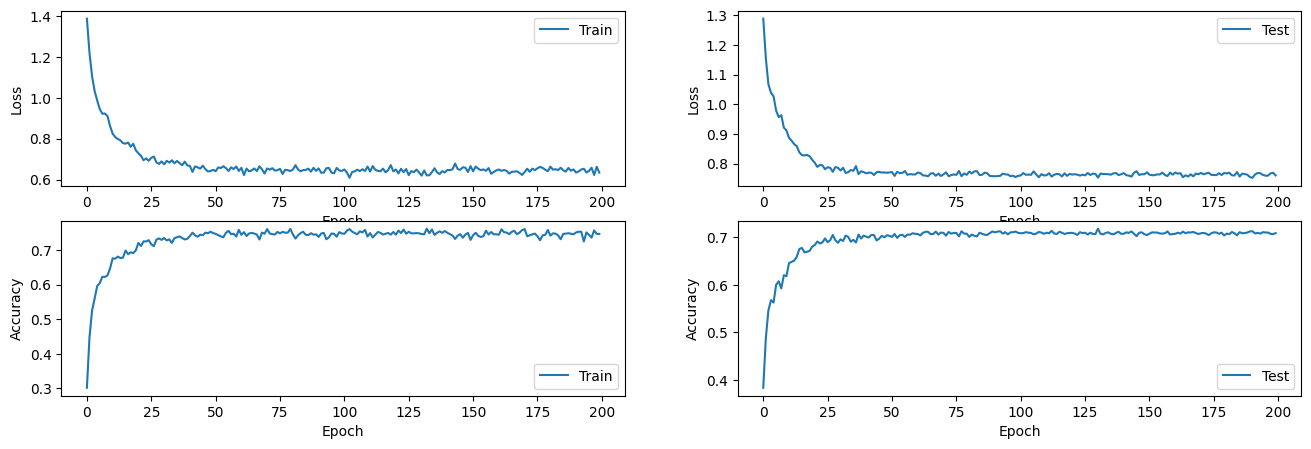

In [16]:
visualize(train_losses, test_losses, train_acc, test_acc)

# 5. Hyper parameters tuning

In [25]:
parameters = {
    "lr": [0.0001, 0.0005, 0.001, 0.005],
    "weight_decay": [0.001, 0.01],
    "step_size": [5, 10, 20],  # Discrete values
    "gamma": [0.1, 0.5, 0.9],
    "batch_size": [8, 16, 32, 64, 128]  # Add batch size options
}

In [37]:
def hyper_tuning_model(model_class, train_dataset, test_dataset, parameters, device, epochs=50, wandb_writer=None, show=False):
    keys, values = zip(*parameters.items())
    combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

    best_params = None
    best_acc = 0
    results = []

    i = 0
    for params_set in combinations:
        batch_size = params_set['batch_size']
        lr = params_set['lr']
        weight_decay = params_set['weight_decay']
        step_size = params_set['step_size']
        gamma = params_set['gamma']

        print(f'Tuning: batch_size={batch_size}, lr={lr}, weight_decay={weight_decay}, step_size={step_size}, gamma={gamma}\n')
        
        model = model_class(num_classes=4)
        
        train_loader = DataLoader(train_dataset, batch_size=params_set['batch_size'], shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=params_set['batch_size'], shuffle=False)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

        save_path = f'/kaggle/working/eeg_net_set{i}.pth'
        i += 1
        train_losses, train_acc, test_losses, test_acc = train_model(model, train_loader, test_loader, 
                                                                     criterion, optimizer, scheduler, 
                                                                     save_path, device, 
                                                                     epochs=epochs, wandb_writer=wandb_writer, show=show)

        if np.max(test_acc) > best_acc:
            best_params = params_set
            best_acc = np.max(test_acc)

        results.append({
            'params': params_set,
            'train_losses': train_losses,
            'train_acc': train_acc,
            'test_losses': test_losses,
            'test_acc': test_acc,
        })
        print("<<<<<<<<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>>>>\n<<<<<<<<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>>>>\n")

    return best_params, best_acc, results
        

In [40]:
best_params, best_acc, results = hyper_tuning_model(EEGNet, train_dataset, test_dataset, parameters, device, epochs=50, wandb_writer=None, show=False)

Tuning: batch_size=8, lr=0.0001, weight_decay=0.001, step_size=5, gamma=0.1

<<<<<<<<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>>>>
<<<<<<<<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>>>>

Tuning: batch_size=16, lr=0.0001, weight_decay=0.001, step_size=5, gamma=0.1

<<<<<<<<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>>>>
<<<<<<<<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>>>>

Tuning: batch_size=32, lr=0.0001, weight_decay=0.001, step_size=5, gamma=0.1

<<<<<<<<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>>>>
<<<<<<<<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>>>>

Tuning: batch_size=64, lr=0.0001, weight_decay=0.001, step_size=5, gamma=0.1

<<<<<<<<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>>>>
<<<<<<<<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>>>>

Tuning: batch_size=128, lr=0.0001, weight_decay=0.001, step_size=5, gamma=0.1

<<<<<<<<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>>>>
<<<<<<<<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>>>>

Tuning: batch_size=8, lr=0.0001, weight_decay=0.001, step_size=5, gamma=0.5

<<<<<<<<

In [41]:
print(f'best_params: {best_params}\nbest_acc: {best_acc}')

best_params: {'lr': 0.005, 'weight_decay': 0.001, 'step_size': 20, 'gamma': 0.5, 'batch_size': 8}
best_acc: 0.7345679012345679


In [44]:
i = 305
results[i]['params']

{'lr': 0.005,
 'weight_decay': 0.001,
 'step_size': 20,
 'gamma': 0.5,
 'batch_size': 8}

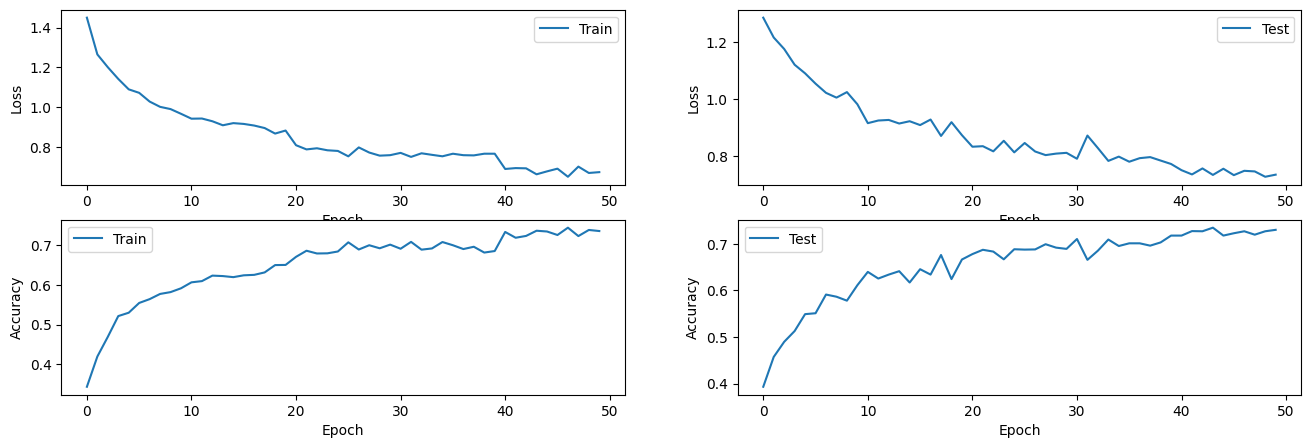

In [46]:
train_losses = results[i]['train_losses']
test_losses = results[i]['test_losses']
train_acc = results[i]['train_acc']
test_acc = results[i]['test_acc']

visualize(train_losses, test_losses, train_acc, test_acc)